## Train Boltzmann Generator on BPTI

Note: training can be very memory intensive and consequently crashes frequently.


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import mdtraj
from deep_boltzmann.networks.training import MLTrainer, FlexibleTrainer
from deep_boltzmann.networks.invertible import invnet, EnergyInvNet
from deep_boltzmann.models.openmm import OpenMMEnergy
import mdtraj as md
from simtk import openmm, unit
import sys, os, shutil
import tensorflow as tf


Using TensorFlow backend.


In [2]:
# Data paths
data_dir = './data/'
pdb_dir = './data/'    
tica_data_folder = "./tica_data/"

Routines for the computation of TICA projections for 2D reaction coordinate loss

In [3]:
def torsion_tf(x1, x2, x3, x4, degrees=True):
    """Praxeolitic formula
    1 sqrt, 1 cross product"""
    b0 = -1.0*(x2 - x1)
    b1 = x3 - x2
    b2 = x4 - x3
    # normalize b1 so that it does not influence magnitude of vector
    # rejections that come next
    b1 /= tf.norm(b1, axis=2, keepdims=True)

    # vector rejections
    # v = projection of b0 onto plane perpendicular to b1
    #   = b0 minus component that aligns with b1
    # w = projection of b2 onto plane perpendicular to b1
    #   = b2 minus component that aligns with b1
    v = b0 - tf.reduce_sum(b0*b1, axis=2, keepdims=True) * b1
    w = b2 - tf.reduce_sum(b2*b1, axis=2, keepdims=True) * b1

    # angle between v and w in a plane is the torsion angle
    # v and w may not be normalized but that's fine since tan is y/x
    x = tf.reduce_sum(v*w, axis=2)
    b1xv = tf.cross(b1, v)
    y = tf.reduce_sum(b1xv*w, axis=2)
    if degrees:
        return np.float32(180.0 / np.pi) * tf.atan2(y, x)
    else:
        return tf.atan2(y, x)


class TorsionTICARC(object):
    def __init__(self, dim, torsion_idx, tica_mean, tica_eig, output_dims=2):
        self.torsion_idx = torsion_idx
        self.tica_mean = tf.constant(tica_mean.astype(np.float32))
        self.tica_eig = tf.constant(tica_eig.astype(np.float32))[:,:output_dims]
        self.atom_indices = np.arange(dim).reshape((-1, 3))
        self.n_torsions = torsion_idx.shape[0]
        self.dim = output_dims

    def __call__(self, x):
        #compute torsions
        torsions = torsion_tf(tf.gather(x, self.atom_indices[self.torsion_idx[:, 0]], axis=1),
                            tf.gather(x, self.atom_indices[self.torsion_idx[:, 1]], axis=1),
                            tf.gather(x, self.atom_indices[self.torsion_idx[:, 2]], axis=1),
                            tf.gather(x, self.atom_indices[self.torsion_idx[:, 3]], axis=1), degrees=False)
        #compute sines and cosines and stack and flatten
        torsion_cossin = tf.reshape(tf.stack([tf.cos(torsions), tf.sin(torsions)], axis=-1), 
                                    [-1, 2*self.n_torsions])
        torsion_cossin_mean_free = torsion_cossin - self.tica_mean
        if self.dim == 1:
            return tf.cast(tf.reshape(tf.matmul(torsion_cossin_mean_free, self.tica_eig), [-1]), tf.float32)
        else:
            return tf.cast(tf.reshape(tf.matmul(torsion_cossin_mean_free, self.tica_eig), [-1, self.dim]), tf.float32)
    


Routines for system setup

In [6]:
def setup_BPTI():
    """ Sets up BPTI Topology and Energy Model

    Returns
    -------
    top : mdtraj Topology object
        BPTI Topology
    energy : Energy object
        Energy model

    """
    INTEGRATOR_ARGS = (300*unit.kelvin, 1.0/unit.picoseconds, 2.0*unit.femtoseconds)

    from simtk.openmm import app
    pdb = app.PDBFile(pdb_dir + 'bpti_top.pdb')
    forcefield = openmm.app.ForceField('amber99sbildn.xml', 'amber99_obc.xml')

    system = forcefield.createSystem(pdb.topology,removeCMMotion=False,
                                     nonbondedMethod=app.CutoffNonPeriodic, nonbondedCutoff=1.0*unit.nanometers,
                                     constraints=None, rigidWater=True)
    integrator = openmm.LangevinIntegrator(300*unit.kelvin, 1.0/unit.picoseconds, 2.0*unit.femtoseconds)
    simulation = openmm.app.Simulation(pdb.topology, system, integrator)

    bpti_omm_energy = OpenMMEnergy(system,
                                   openmm.LangevinIntegrator,
                                   unit.nanometers,
                                   n_atoms=md.Topology().from_openmm(simulation.topology).n_atoms,
                                   openmm_integrator_args=INTEGRATOR_ARGS)

    mdtraj_topology = md.Topology().from_openmm(pdb.topology)
    return mdtraj_topology, bpti_omm_energy

def get_indices(top, cartesian_CYS=True):
    """ Returns Cartesian and IC indices

    Returns
    -------
    cart : array
        Cartesian atom selection
    Z : array
        Z index matrix

    """
    from deep_boltzmann.models.proteins import mdtraj2Z
    cartesian = ['CA', 'C', 'N']
    cart = top.select(' '.join(["name " + s for s in cartesian]))
    if cartesian_CYS:
        Z_, _carts = mdtraj2Z(top,  cartesian="resname CYS and mass>2 and sidechain")
        Z_ = np.array(Z_)
        cart = np.sort(np.concatenate((cart,_carts)))
    else:
        Z_ = np.array(mdtraj2Z(top))
    return cart, Z_

def train_ML(bg, xtrain, epochs, batch_sizes):
    trainer_ML = MLTrainer(bg, lr=0.001)
    for batch_size in batch_sizes:
        trainer_ML.train(xtrain, epochs=epochs, batch_size=batch_size)

def train_KL(bg, xtrain, epochs, high_energies, w_KLs, stage=0, rc_func=None, rc_min=-1, 
             rc_max=6, w_RC=1., w_L2_angle=0.):
    trainers_KL_state3 = []
    for current_stage in range(stage, len(epochs)):
        print('-----------------------')
        print(high_energies[current_stage], w_KLs[current_stage])
        sys.stdout.flush()
        flextrainer = FlexibleTrainer(bg, lr=0.0001, batch_size=5000,
                                      high_energy=high_energies[current_stage], max_energy=1e20,
                                      w_KL=w_KLs[current_stage], w_ML=1, weigh_ML=False, w_RC=w_RC,
                                      rc_func=rc_func, rc_min=np.array(rc_min), rc_max=np.array(rc_max),
                                      w_L2_angle=w_L2_angle, 
                                      rc_dims=rc_func.dim)
        flextrainer.train(xtrain, epochs=epochs[current_stage])
        trainers_KL_state3.append(flextrainer)

        # Analyze
        samples_z = np.random.randn(10000, bg.dim)
        samples_x = bg.Tzx.predict(samples_z)
        samples_e = bg.energy_model.energy(samples_x)
        energy_violations = [np.count_nonzero(samples_e > E) for E in high_energies]
        print('Energy violations:')
        for E, V in zip(high_energies, energy_violations):
            print(V, '\t>\t', E)
        sys.stdout.flush()

        # SAVE
        bg.save('./BG_intermediate_model_saved.pkl')
        saveconfig = {}
        saveconfig['stage'] = current_stage
        #np.savez_compressed('config_save.npz', **saveconfig)
        print('Intermediate result saved')
        sys.stdout.flush()




In [7]:
# set up BPTI
top, mm_bpti = setup_BPTI()
print('BPTI set up\n')
sys.stdout.flush()

#setup TICA computation
TicaRC = TorsionTICARC(mm_bpti.dim, np.load(tica_data_folder+"/torsion_idx.npy"), 
                          np.load(tica_data_folder+"/tica_mean.npy"), 
                          np.load(tica_data_folder+"/tica_eig_intern.npy"), output_dims=2)

#load training data for ML loss
sim_x = np.load(data_dir + "training_data.npy")

# Superimpose frames and reshuffle 
nframes = sim_x.shape[0]
dim = sim_x.shape[1]
sim_x_traj = mdtraj.Trajectory(sim_x.reshape((nframes, int(dim/3), 3)), top)
sim_x_traj = sim_x_traj.superpose(sim_x_traj[0], atom_indices=top.select('backbone'))
sim_x = sim_x_traj.xyz.reshape((nframes, -1))
np.random.shuffle(sim_x)

print('Data loaded\n')
sys.stdout.flush()

BPTI set up

Data loaded



# Training BG
Below are routines to build and train the BG (takes about 10-12 hrs on a standard desktop, less if GPUs can be used)

If you want to skip this you can skip down a re-load a pre-loaded model: [here](#Load-pre-trained-model)

In [8]:
%%bash
hostname

moray


In [10]:
print(f"Number of frames in training data {nframes} and dimensionality {dim}")

Number of frames in training data 150000 and dimensionality 2676


In [12]:
# Get indices for dimensions represented by cartesian and internal coordinates respectively
CartIndices, ZIndices = get_indices(top, cartesian_CYS=True)

In [13]:
# Construct Boltzmann Generator object 
bg = invnet(dim, 'R'*8, energy_model=mm_bpti,
            ic=ZIndices, ic_cart=CartIndices, ic_norm=sim_x,
            nl_layers=4, nl_hidden=[256, 128, 256], nl_activation='relu', nl_activation_scale='tanh')
print('BG constructed\n')
sys.stdout.flush()


I<RRRRRRRR>
I 2676 0 0
< 2670 0 6
R 1335 1335 6
R 1335 1335 6
R 1335 1335 6
R 1335 1335 6
R 1335 1335 6
R 1335 1335 6
R 1335 1335 6
R 1335 1335 6
> 1335 1335 6
Before connect
 layer 0
 layer 1
 layer 2
 layer 3
 layer 4
 layer 5
 layer 6
 layer 7
 layer 8
 layer 9
 layer 10
Done xz
 layer 10
 layer 9
 layer 8
 layer 7
 layer 6
 layer 5
 layer 4
 layer 3
 layer 2
 layer 1
 layer 0
 IC layer: connect_zx
 IC layer: z2x
 IC layer: z2x_jacobian
 IC layer: done connecting.
Done zx
BG constructed



In [14]:
# Perform ML training -- Three epochs with increasing batch sizes
epochs_ML = 2000
batch_sizes_ML = [128, 256, 512]
train_ML(bg, sim_x, epochs_ML, batch_sizes_ML)
bg.save('./BG_save_after_ML.pkl')

print('ML training done\n')
sys.stdout.flush()

Compiling the graph
Epoch 0/2000 loss -9249.8623 
Epoch 1/2000 loss -9801.0771 
Epoch 2/2000 loss -9843.2871 
Epoch 3/2000 loss -9846.1738 
Epoch 4/2000 loss -9886.9727 
Epoch 5/2000 loss -9909.8809 
Epoch 6/2000 loss -9931.1758 
Epoch 7/2000 loss -9948.6934 
Epoch 8/2000 loss -9966.3945 
Epoch 9/2000 loss -9984.7803 
Epoch 10/2000 loss -9984.3457 
Epoch 11/2000 loss -9986.7500 
Epoch 12/2000 loss -9994.9365 
Epoch 13/2000 loss -9988.0449 
Epoch 14/2000 loss -10001.9307 
Epoch 15/2000 loss -10003.8145 
Epoch 16/2000 loss -10008.7939 
Epoch 17/2000 loss -10006.8008 
Epoch 18/2000 loss -10015.5410 
Epoch 19/2000 loss -10007.6289 
Epoch 20/2000 loss -10020.3896 
Epoch 21/2000 loss -10012.5645 
Epoch 22/2000 loss -10023.9336 
Epoch 23/2000 loss -10015.2344 
Epoch 24/2000 loss -10011.9287 
Epoch 25/2000 loss -10020.6367 
Epoch 26/2000 loss -10029.4814 
Epoch 27/2000 loss -10024.4209 
Epoch 28/2000 loss -10028.4941 
Epoch 29/2000 loss -10026.0381 
Epoch 30/2000 loss -10029.3027 
Epoch 31/200

Epoch 252/2000 loss -10138.9922 
Epoch 253/2000 loss -10137.8125 
Epoch 254/2000 loss -10133.5410 
Epoch 255/2000 loss -10133.5986 
Epoch 256/2000 loss -10132.8975 
Epoch 257/2000 loss -10134.3848 
Epoch 258/2000 loss -10146.2695 
Epoch 259/2000 loss -10138.8643 
Epoch 260/2000 loss -10137.5977 
Epoch 261/2000 loss -10130.4531 
Epoch 262/2000 loss -10149.0625 
Epoch 263/2000 loss -10136.7305 
Epoch 264/2000 loss -10142.2412 
Epoch 265/2000 loss -10133.2744 
Epoch 266/2000 loss -10138.9004 
Epoch 267/2000 loss -10137.3086 
Epoch 268/2000 loss -10133.4961 
Epoch 269/2000 loss -10142.4336 
Epoch 270/2000 loss -10138.4453 
Epoch 271/2000 loss -10144.0859 
Epoch 272/2000 loss -10145.1924 
Epoch 273/2000 loss -10146.3574 
Epoch 274/2000 loss -10144.6855 
Epoch 275/2000 loss -10140.3262 
Epoch 276/2000 loss -10147.7793 
Epoch 277/2000 loss -10154.1621 
Epoch 278/2000 loss -10144.6602 
Epoch 279/2000 loss -10148.6211 
Epoch 280/2000 loss -10140.5215 
Epoch 281/2000 loss -10146.8545 
Epoch 282/

Epoch 501/2000 loss -10175.9482 
Epoch 502/2000 loss -10171.4482 
Epoch 503/2000 loss -10166.2031 
Epoch 504/2000 loss -10181.5547 
Epoch 505/2000 loss -10179.3281 
Epoch 506/2000 loss -10174.7373 
Epoch 507/2000 loss -10170.1279 
Epoch 508/2000 loss -10164.3574 
Epoch 509/2000 loss -10179.1494 
Epoch 510/2000 loss -10183.2979 
Epoch 511/2000 loss -10184.3994 
Epoch 512/2000 loss -10181.3418 
Epoch 513/2000 loss -10170.9746 
Epoch 514/2000 loss -10171.7383 
Epoch 515/2000 loss -10178.9688 
Epoch 516/2000 loss -10176.6074 
Epoch 517/2000 loss -10173.7207 
Epoch 518/2000 loss -10179.4717 
Epoch 519/2000 loss -10173.4609 
Epoch 520/2000 loss -10185.1416 
Epoch 521/2000 loss -10177.9590 
Epoch 522/2000 loss -10172.0684 
Epoch 523/2000 loss -10176.3789 
Epoch 524/2000 loss -10166.8770 
Epoch 525/2000 loss -10173.6279 
Epoch 526/2000 loss -10175.2764 
Epoch 527/2000 loss -10176.4180 
Epoch 528/2000 loss -10173.5801 
Epoch 529/2000 loss -10174.6504 
Epoch 530/2000 loss -10183.4629 
Epoch 531/

Epoch 750/2000 loss -10204.1211 
Epoch 751/2000 loss -10201.7266 
Epoch 752/2000 loss -10205.6191 
Epoch 753/2000 loss -10202.4805 
Epoch 754/2000 loss -10194.7734 
Epoch 755/2000 loss -10204.3730 
Epoch 756/2000 loss -10206.5059 
Epoch 757/2000 loss -10202.0957 
Epoch 758/2000 loss -10203.7285 
Epoch 759/2000 loss -10207.5723 
Epoch 760/2000 loss -10203.5059 
Epoch 761/2000 loss -10199.0947 
Epoch 762/2000 loss -10211.5518 
Epoch 763/2000 loss -10196.3984 
Epoch 764/2000 loss -10205.0420 
Epoch 765/2000 loss -10200.4189 
Epoch 766/2000 loss -10205.5049 
Epoch 767/2000 loss -10197.9180 
Epoch 768/2000 loss -10198.5283 
Epoch 769/2000 loss -10196.5605 
Epoch 770/2000 loss -10194.7393 
Epoch 771/2000 loss -10190.7295 
Epoch 772/2000 loss -10196.7402 
Epoch 773/2000 loss -10194.6816 
Epoch 774/2000 loss -10211.6621 
Epoch 775/2000 loss -10210.4121 
Epoch 776/2000 loss -10189.8477 
Epoch 777/2000 loss -10198.8047 
Epoch 778/2000 loss -10197.9658 
Epoch 779/2000 loss -10198.0352 
Epoch 780/

Epoch 999/2000 loss -10211.0859 
Epoch 1000/2000 loss -10213.8984 
Epoch 1001/2000 loss -10220.9287 
Epoch 1002/2000 loss -10213.7031 
Epoch 1003/2000 loss -10216.3730 
Epoch 1004/2000 loss -10225.0293 
Epoch 1005/2000 loss -10219.6445 
Epoch 1006/2000 loss -10214.6855 
Epoch 1007/2000 loss -10213.3613 
Epoch 1008/2000 loss -10220.8613 
Epoch 1009/2000 loss -10223.0811 
Epoch 1010/2000 loss -10220.0957 
Epoch 1011/2000 loss -10218.4795 
Epoch 1012/2000 loss -10208.9141 
Epoch 1013/2000 loss -10213.0449 
Epoch 1014/2000 loss -10223.7246 
Epoch 1015/2000 loss -10216.9766 
Epoch 1016/2000 loss -10220.2012 
Epoch 1017/2000 loss -10220.9531 
Epoch 1018/2000 loss -10215.0322 
Epoch 1019/2000 loss -10212.3623 
Epoch 1020/2000 loss -10216.6777 
Epoch 1021/2000 loss -10217.0840 
Epoch 1022/2000 loss -10217.9160 
Epoch 1023/2000 loss -10211.3613 
Epoch 1024/2000 loss -10220.5527 
Epoch 1025/2000 loss -10212.7910 
Epoch 1026/2000 loss -10209.4502 
Epoch 1027/2000 loss -10221.4561 
Epoch 1028/2000

Epoch 1240/2000 loss -10231.3906 
Epoch 1241/2000 loss -10238.8555 
Epoch 1242/2000 loss -10241.2969 
Epoch 1243/2000 loss -10229.3613 
Epoch 1244/2000 loss -10234.4805 
Epoch 1245/2000 loss -10222.8467 
Epoch 1246/2000 loss -10240.5166 
Epoch 1247/2000 loss -10230.4707 
Epoch 1248/2000 loss -10223.5322 
Epoch 1249/2000 loss -10230.1611 
Epoch 1250/2000 loss -10216.8867 
Epoch 1251/2000 loss -10228.3027 
Epoch 1252/2000 loss -10235.0625 
Epoch 1253/2000 loss -10232.8457 
Epoch 1254/2000 loss -10231.4707 
Epoch 1255/2000 loss -10240.1602 
Epoch 1256/2000 loss -10230.1729 
Epoch 1257/2000 loss -10231.6699 
Epoch 1258/2000 loss -10222.2754 
Epoch 1259/2000 loss -10236.4033 
Epoch 1260/2000 loss -10234.8291 
Epoch 1261/2000 loss -10232.1621 
Epoch 1262/2000 loss -10227.9648 
Epoch 1263/2000 loss -10231.7871 
Epoch 1264/2000 loss -10228.9541 
Epoch 1265/2000 loss -10239.0332 
Epoch 1266/2000 loss -10223.4873 
Epoch 1267/2000 loss -10233.9795 
Epoch 1268/2000 loss -10230.5088 
Epoch 1269/200

Epoch 1481/2000 loss -10243.3613 
Epoch 1482/2000 loss -10245.9375 
Epoch 1483/2000 loss -10249.8271 
Epoch 1484/2000 loss -10239.6758 
Epoch 1485/2000 loss -10251.1670 
Epoch 1486/2000 loss -10244.8047 
Epoch 1487/2000 loss -10252.1328 
Epoch 1488/2000 loss -10239.6982 
Epoch 1489/2000 loss -10245.5850 
Epoch 1490/2000 loss -10240.1230 
Epoch 1491/2000 loss -10239.2734 
Epoch 1492/2000 loss -10254.9307 
Epoch 1493/2000 loss -10250.6113 
Epoch 1494/2000 loss -10250.3213 
Epoch 1495/2000 loss -10251.3613 
Epoch 1496/2000 loss -10241.5361 
Epoch 1497/2000 loss -10246.7158 
Epoch 1498/2000 loss -10242.5957 
Epoch 1499/2000 loss -10244.8555 
Epoch 1500/2000 loss -10248.0078 
Epoch 1501/2000 loss -10243.9053 
Epoch 1502/2000 loss -10251.0420 
Epoch 1503/2000 loss -10247.3916 
Epoch 1504/2000 loss -10244.7227 
Epoch 1505/2000 loss -10243.2168 
Epoch 1506/2000 loss -10248.2324 
Epoch 1507/2000 loss -10242.7715 
Epoch 1508/2000 loss -10247.7607 
Epoch 1509/2000 loss -10246.5186 
Epoch 1510/200

Epoch 1722/2000 loss -10258.8936 
Epoch 1723/2000 loss -10260.7559 
Epoch 1724/2000 loss -10263.7393 
Epoch 1725/2000 loss -10259.2822 
Epoch 1726/2000 loss -10269.3379 
Epoch 1727/2000 loss -10267.1172 
Epoch 1728/2000 loss -10263.6445 
Epoch 1729/2000 loss -10264.5674 
Epoch 1730/2000 loss -10255.4111 
Epoch 1731/2000 loss -10262.3916 
Epoch 1732/2000 loss -10258.8105 
Epoch 1733/2000 loss -10257.5508 
Epoch 1734/2000 loss -10258.8691 
Epoch 1735/2000 loss -10258.8633 
Epoch 1736/2000 loss -10262.4648 
Epoch 1737/2000 loss -10262.7031 
Epoch 1738/2000 loss -10252.8379 
Epoch 1739/2000 loss -10253.7129 
Epoch 1740/2000 loss -10267.1094 
Epoch 1741/2000 loss -10247.4287 
Epoch 1742/2000 loss -10256.1035 
Epoch 1743/2000 loss -10272.2695 
Epoch 1744/2000 loss -10253.8848 
Epoch 1745/2000 loss -10249.0176 
Epoch 1746/2000 loss -10242.8711 
Epoch 1747/2000 loss -10256.8057 
Epoch 1748/2000 loss -10246.7168 
Epoch 1749/2000 loss -10253.2539 
Epoch 1750/2000 loss -10251.6924 
Epoch 1751/200

Epoch 1963/2000 loss -10257.5938 
Epoch 1964/2000 loss -10263.2305 
Epoch 1965/2000 loss -10264.8711 
Epoch 1966/2000 loss -10262.4277 
Epoch 1967/2000 loss -10267.0254 
Epoch 1968/2000 loss -10265.4805 
Epoch 1969/2000 loss -10279.4414 
Epoch 1970/2000 loss -10267.4551 
Epoch 1971/2000 loss -10257.3262 
Epoch 1972/2000 loss -10257.5176 
Epoch 1973/2000 loss -10277.1182 
Epoch 1974/2000 loss -10267.7363 
Epoch 1975/2000 loss -10270.8262 
Epoch 1976/2000 loss -10270.8799 
Epoch 1977/2000 loss -10266.6670 
Epoch 1978/2000 loss -10270.8340 
Epoch 1979/2000 loss -10261.5605 
Epoch 1980/2000 loss -10266.8730 
Epoch 1981/2000 loss -10257.8125 
Epoch 1982/2000 loss -10272.1777 
Epoch 1983/2000 loss -10266.5283 
Epoch 1984/2000 loss -10260.3047 
Epoch 1985/2000 loss -10256.3555 
Epoch 1986/2000 loss -10264.2812 
Epoch 1987/2000 loss -10262.1523 
Epoch 1988/2000 loss -10270.3623 
Epoch 1989/2000 loss -10267.2734 
Epoch 1990/2000 loss -10259.7363 
Epoch 1991/2000 loss -10265.7656 
Epoch 1992/200

Epoch 214/2000 loss -10301.0273 
Epoch 215/2000 loss -10307.3223 
Epoch 216/2000 loss -10300.6562 
Epoch 217/2000 loss -10295.5547 
Epoch 218/2000 loss -10295.0137 
Epoch 219/2000 loss -10296.2871 
Epoch 220/2000 loss -10295.6396 
Epoch 221/2000 loss -10292.7910 
Epoch 222/2000 loss -10298.9092 
Epoch 223/2000 loss -10295.5176 
Epoch 224/2000 loss -10299.4326 
Epoch 225/2000 loss -10294.7666 
Epoch 226/2000 loss -10297.2012 
Epoch 227/2000 loss -10299.8203 
Epoch 228/2000 loss -10294.2324 
Epoch 229/2000 loss -10301.6328 
Epoch 230/2000 loss -10303.2129 
Epoch 231/2000 loss -10299.3193 
Epoch 232/2000 loss -10307.8281 
Epoch 233/2000 loss -10302.7402 
Epoch 234/2000 loss -10306.7734 
Epoch 235/2000 loss -10300.7900 
Epoch 236/2000 loss -10298.0645 
Epoch 237/2000 loss -10301.1611 
Epoch 238/2000 loss -10295.3516 
Epoch 239/2000 loss -10306.9590 
Epoch 240/2000 loss -10309.2207 
Epoch 241/2000 loss -10299.5352 
Epoch 242/2000 loss -10305.1211 
Epoch 243/2000 loss -10297.9951 
Epoch 244/

Epoch 463/2000 loss -10303.6914 
Epoch 464/2000 loss -10305.2988 
Epoch 465/2000 loss -10310.4404 
Epoch 466/2000 loss -10303.1738 
Epoch 467/2000 loss -10309.2891 
Epoch 468/2000 loss -10312.2510 
Epoch 469/2000 loss -10309.3203 
Epoch 470/2000 loss -10311.6562 
Epoch 471/2000 loss -10308.2422 
Epoch 472/2000 loss -10317.7734 
Epoch 473/2000 loss -10313.1709 
Epoch 474/2000 loss -10315.4648 
Epoch 475/2000 loss -10319.6699 
Epoch 476/2000 loss -10309.0957 
Epoch 477/2000 loss -10317.5996 
Epoch 478/2000 loss -10311.0127 
Epoch 479/2000 loss -10314.2695 
Epoch 480/2000 loss -10309.6348 
Epoch 481/2000 loss -10317.9375 
Epoch 482/2000 loss -10314.4766 
Epoch 483/2000 loss -10315.9062 
Epoch 484/2000 loss -10310.2012 
Epoch 485/2000 loss -10312.1641 
Epoch 486/2000 loss -10312.3037 
Epoch 487/2000 loss -10309.9668 
Epoch 488/2000 loss -10313.1182 
Epoch 489/2000 loss -10316.2031 
Epoch 490/2000 loss -10309.1406 
Epoch 491/2000 loss -10312.9648 
Epoch 492/2000 loss -10314.4639 
Epoch 493/

Epoch 712/2000 loss -10315.7432 
Epoch 713/2000 loss -10321.1348 
Epoch 714/2000 loss -10322.3672 
Epoch 715/2000 loss -10325.5459 
Epoch 716/2000 loss -10326.0684 
Epoch 717/2000 loss -10324.2012 
Epoch 718/2000 loss -10330.2520 
Epoch 719/2000 loss -10321.0049 
Epoch 720/2000 loss -10322.4424 
Epoch 721/2000 loss -10330.3740 
Epoch 722/2000 loss -10321.1484 
Epoch 723/2000 loss -10322.6309 
Epoch 724/2000 loss -10326.9434 
Epoch 725/2000 loss -10320.1885 
Epoch 726/2000 loss -10329.8223 
Epoch 727/2000 loss -10327.3438 
Epoch 728/2000 loss -10323.1729 
Epoch 729/2000 loss -10314.1143 
Epoch 730/2000 loss -10318.3262 
Epoch 731/2000 loss -10326.3965 
Epoch 732/2000 loss -10328.7324 
Epoch 733/2000 loss -10320.5781 
Epoch 734/2000 loss -10323.3584 
Epoch 735/2000 loss -10326.7812 
Epoch 736/2000 loss -10322.7715 
Epoch 737/2000 loss -10317.9473 
Epoch 738/2000 loss -10320.4707 
Epoch 739/2000 loss -10320.0469 
Epoch 740/2000 loss -10318.5645 
Epoch 741/2000 loss -10327.6230 
Epoch 742/

Epoch 961/2000 loss -10326.6992 
Epoch 962/2000 loss -10326.9033 
Epoch 963/2000 loss -10328.3848 
Epoch 964/2000 loss -10324.7207 
Epoch 965/2000 loss -10326.4229 
Epoch 966/2000 loss -10333.9766 
Epoch 967/2000 loss -10338.6719 
Epoch 968/2000 loss -10327.2188 
Epoch 969/2000 loss -10331.9805 
Epoch 970/2000 loss -10337.8398 
Epoch 971/2000 loss -10329.4316 
Epoch 972/2000 loss -10334.6836 
Epoch 973/2000 loss -10336.0469 
Epoch 974/2000 loss -10332.5225 
Epoch 975/2000 loss -10328.1143 
Epoch 976/2000 loss -10333.7070 
Epoch 977/2000 loss -10336.9863 
Epoch 978/2000 loss -10330.5547 
Epoch 979/2000 loss -10332.1377 
Epoch 980/2000 loss -10329.5156 
Epoch 981/2000 loss -10330.8838 
Epoch 982/2000 loss -10337.0527 
Epoch 983/2000 loss -10326.5898 
Epoch 984/2000 loss -10328.7314 
Epoch 985/2000 loss -10324.5781 
Epoch 986/2000 loss -10330.3145 
Epoch 987/2000 loss -10331.7705 
Epoch 988/2000 loss -10331.5986 
Epoch 989/2000 loss -10327.4639 
Epoch 990/2000 loss -10332.4795 
Epoch 991/

Epoch 1204/2000 loss -10337.5801 
Epoch 1205/2000 loss -10337.1680 
Epoch 1206/2000 loss -10341.7207 
Epoch 1207/2000 loss -10336.7363 
Epoch 1208/2000 loss -10333.1094 
Epoch 1209/2000 loss -10342.8477 
Epoch 1210/2000 loss -10332.6270 
Epoch 1211/2000 loss -10337.1738 
Epoch 1212/2000 loss -10338.8926 
Epoch 1213/2000 loss -10336.9492 
Epoch 1214/2000 loss -10337.7783 
Epoch 1215/2000 loss -10340.2500 
Epoch 1216/2000 loss -10333.3281 
Epoch 1217/2000 loss -10345.1719 
Epoch 1218/2000 loss -10339.2510 
Epoch 1219/2000 loss -10339.2666 
Epoch 1220/2000 loss -10336.3184 
Epoch 1221/2000 loss -10340.2236 
Epoch 1222/2000 loss -10343.6807 
Epoch 1223/2000 loss -10332.8291 
Epoch 1224/2000 loss -10339.9277 
Epoch 1225/2000 loss -10339.8789 
Epoch 1226/2000 loss -10334.1367 
Epoch 1227/2000 loss -10333.3770 
Epoch 1228/2000 loss -10332.7900 
Epoch 1229/2000 loss -10336.8203 
Epoch 1230/2000 loss -10339.4199 
Epoch 1231/2000 loss -10334.2334 
Epoch 1232/2000 loss -10341.3984 
Epoch 1233/200

Epoch 1445/2000 loss -10342.7363 
Epoch 1446/2000 loss -10345.1826 
Epoch 1447/2000 loss -10349.3496 
Epoch 1448/2000 loss -10337.2402 
Epoch 1449/2000 loss -10342.0039 
Epoch 1450/2000 loss -10343.9668 
Epoch 1451/2000 loss -10352.6924 
Epoch 1452/2000 loss -10346.8291 
Epoch 1453/2000 loss -10336.2969 
Epoch 1454/2000 loss -10342.4824 
Epoch 1455/2000 loss -10346.5566 
Epoch 1456/2000 loss -10345.6172 
Epoch 1457/2000 loss -10350.4824 
Epoch 1458/2000 loss -10344.5762 
Epoch 1459/2000 loss -10344.9756 
Epoch 1460/2000 loss -10339.6348 
Epoch 1461/2000 loss -10337.0645 
Epoch 1462/2000 loss -10344.9180 
Epoch 1463/2000 loss -10339.2227 
Epoch 1464/2000 loss -10339.8135 
Epoch 1465/2000 loss -10350.6895 
Epoch 1466/2000 loss -10344.5996 
Epoch 1467/2000 loss -10348.4229 
Epoch 1468/2000 loss -10347.9346 
Epoch 1469/2000 loss -10345.6338 
Epoch 1470/2000 loss -10341.4453 
Epoch 1471/2000 loss -10346.1006 
Epoch 1472/2000 loss -10341.4648 
Epoch 1473/2000 loss -10348.5967 
Epoch 1474/200

Epoch 1686/2000 loss -10349.0059 
Epoch 1687/2000 loss -10352.2559 
Epoch 1688/2000 loss -10349.3008 
Epoch 1689/2000 loss -10358.0684 
Epoch 1690/2000 loss -10346.0176 
Epoch 1691/2000 loss -10349.8770 
Epoch 1692/2000 loss -10358.6768 
Epoch 1693/2000 loss -10352.2754 
Epoch 1694/2000 loss -10347.8496 
Epoch 1695/2000 loss -10356.3262 
Epoch 1696/2000 loss -10354.4414 
Epoch 1697/2000 loss -10347.9902 
Epoch 1698/2000 loss -10355.4941 
Epoch 1699/2000 loss -10344.5469 
Epoch 1700/2000 loss -10358.6035 
Epoch 1701/2000 loss -10354.8340 
Epoch 1702/2000 loss -10358.0078 
Epoch 1703/2000 loss -10354.7188 
Epoch 1704/2000 loss -10351.2109 
Epoch 1705/2000 loss -10357.3711 
Epoch 1706/2000 loss -10351.3496 
Epoch 1707/2000 loss -10353.2959 
Epoch 1708/2000 loss -10353.6543 
Epoch 1709/2000 loss -10350.7100 
Epoch 1710/2000 loss -10354.3330 
Epoch 1711/2000 loss -10354.6123 
Epoch 1712/2000 loss -10343.6230 
Epoch 1713/2000 loss -10346.9990 
Epoch 1714/2000 loss -10345.5684 
Epoch 1715/200

Epoch 1927/2000 loss -10353.6699 
Epoch 1928/2000 loss -10353.9570 
Epoch 1929/2000 loss -10347.2783 
Epoch 1930/2000 loss -10360.9180 
Epoch 1931/2000 loss -10357.2070 
Epoch 1932/2000 loss -10354.0791 
Epoch 1933/2000 loss -10349.2227 
Epoch 1934/2000 loss -10355.0078 
Epoch 1935/2000 loss -10361.7266 
Epoch 1936/2000 loss -10362.5352 
Epoch 1937/2000 loss -10354.9082 
Epoch 1938/2000 loss -10355.1348 
Epoch 1939/2000 loss -10354.7109 
Epoch 1940/2000 loss -10354.1035 
Epoch 1941/2000 loss -10355.6152 
Epoch 1942/2000 loss -10351.4258 
Epoch 1943/2000 loss -10358.5117 
Epoch 1944/2000 loss -10360.8633 
Epoch 1945/2000 loss -10357.7109 
Epoch 1946/2000 loss -10356.3203 
Epoch 1947/2000 loss -10357.0098 
Epoch 1948/2000 loss -10345.9678 
Epoch 1949/2000 loss -10356.3311 
Epoch 1950/2000 loss -10362.0020 
Epoch 1951/2000 loss -10360.9688 
Epoch 1952/2000 loss -10354.5840 
Epoch 1953/2000 loss -10356.8691 
Epoch 1954/2000 loss -10368.9121 
Epoch 1955/2000 loss -10357.7871 
Epoch 1956/200

Epoch 177/2000 loss -10385.6514 
Epoch 178/2000 loss -10381.3672 
Epoch 179/2000 loss -10385.1660 
Epoch 180/2000 loss -10386.9844 
Epoch 181/2000 loss -10388.0703 
Epoch 182/2000 loss -10389.1631 
Epoch 183/2000 loss -10380.4277 
Epoch 184/2000 loss -10385.4512 
Epoch 185/2000 loss -10389.7852 
Epoch 186/2000 loss -10389.4316 
Epoch 187/2000 loss -10385.2949 
Epoch 188/2000 loss -10386.5469 
Epoch 189/2000 loss -10383.8496 
Epoch 190/2000 loss -10382.9180 
Epoch 191/2000 loss -10386.7969 
Epoch 192/2000 loss -10388.3965 
Epoch 193/2000 loss -10389.4678 
Epoch 194/2000 loss -10389.6152 
Epoch 195/2000 loss -10387.9727 
Epoch 196/2000 loss -10384.3965 
Epoch 197/2000 loss -10386.6738 
Epoch 198/2000 loss -10386.1328 
Epoch 199/2000 loss -10387.1943 
Epoch 200/2000 loss -10388.6855 
Epoch 201/2000 loss -10386.0518 
Epoch 202/2000 loss -10389.1016 
Epoch 203/2000 loss -10383.3398 
Epoch 204/2000 loss -10385.9932 
Epoch 205/2000 loss -10385.9590 
Epoch 206/2000 loss -10383.2217 
Epoch 207/

Epoch 426/2000 loss -10399.2305 
Epoch 427/2000 loss -10389.8984 
Epoch 428/2000 loss -10394.0234 
Epoch 429/2000 loss -10394.7832 
Epoch 430/2000 loss -10392.4805 
Epoch 431/2000 loss -10389.8809 
Epoch 432/2000 loss -10396.5156 
Epoch 433/2000 loss -10396.0742 
Epoch 434/2000 loss -10392.9482 
Epoch 435/2000 loss -10391.2617 
Epoch 436/2000 loss -10390.5156 
Epoch 437/2000 loss -10390.7715 
Epoch 438/2000 loss -10391.8818 
Epoch 439/2000 loss -10394.6113 
Epoch 440/2000 loss -10393.0215 
Epoch 441/2000 loss -10391.5889 
Epoch 442/2000 loss -10392.0762 
Epoch 443/2000 loss -10395.7588 
Epoch 444/2000 loss -10398.4238 
Epoch 445/2000 loss -10400.9160 
Epoch 446/2000 loss -10392.4629 
Epoch 447/2000 loss -10394.1094 
Epoch 448/2000 loss -10395.3438 
Epoch 449/2000 loss -10398.0898 
Epoch 450/2000 loss -10391.9209 
Epoch 451/2000 loss -10397.8613 
Epoch 452/2000 loss -10388.8730 
Epoch 453/2000 loss -10396.6875 
Epoch 454/2000 loss -10396.3828 
Epoch 455/2000 loss -10395.0801 
Epoch 456/

Epoch 675/2000 loss -10399.4121 
Epoch 676/2000 loss -10402.5723 
Epoch 677/2000 loss -10407.6973 
Epoch 678/2000 loss -10398.7754 
Epoch 679/2000 loss -10404.7842 
Epoch 680/2000 loss -10401.4912 
Epoch 681/2000 loss -10401.0449 
Epoch 682/2000 loss -10402.4785 
Epoch 683/2000 loss -10405.2090 
Epoch 684/2000 loss -10396.1172 
Epoch 685/2000 loss -10399.0039 
Epoch 686/2000 loss -10400.8574 
Epoch 687/2000 loss -10402.3428 
Epoch 688/2000 loss -10405.2627 
Epoch 689/2000 loss -10405.4473 
Epoch 690/2000 loss -10403.4648 
Epoch 691/2000 loss -10403.8750 
Epoch 692/2000 loss -10403.0986 
Epoch 693/2000 loss -10404.4404 
Epoch 694/2000 loss -10403.8975 
Epoch 695/2000 loss -10407.2070 
Epoch 696/2000 loss -10404.5605 
Epoch 697/2000 loss -10401.4258 
Epoch 698/2000 loss -10400.5547 
Epoch 699/2000 loss -10404.5361 
Epoch 700/2000 loss -10402.6973 
Epoch 701/2000 loss -10402.4160 
Epoch 702/2000 loss -10408.1074 
Epoch 703/2000 loss -10401.8486 
Epoch 704/2000 loss -10400.3340 
Epoch 705/

Epoch 924/2000 loss -10404.1328 
Epoch 925/2000 loss -10404.8242 
Epoch 926/2000 loss -10406.7852 
Epoch 927/2000 loss -10413.2871 
Epoch 928/2000 loss -10412.4385 
Epoch 929/2000 loss -10406.1602 
Epoch 930/2000 loss -10414.4453 
Epoch 931/2000 loss -10407.6680 
Epoch 932/2000 loss -10410.7109 
Epoch 933/2000 loss -10407.3115 
Epoch 934/2000 loss -10410.6729 
Epoch 935/2000 loss -10407.8398 
Epoch 936/2000 loss -10407.5176 
Epoch 937/2000 loss -10400.9678 
Epoch 938/2000 loss -10410.2246 
Epoch 939/2000 loss -10401.2842 
Epoch 940/2000 loss -10405.6689 
Epoch 941/2000 loss -10408.6230 
Epoch 942/2000 loss -10404.4102 
Epoch 943/2000 loss -10404.8750 
Epoch 944/2000 loss -10409.3574 
Epoch 945/2000 loss -10407.3691 
Epoch 946/2000 loss -10414.7510 
Epoch 947/2000 loss -10405.9355 
Epoch 948/2000 loss -10405.0762 
Epoch 949/2000 loss -10405.2812 
Epoch 950/2000 loss -10406.6182 
Epoch 951/2000 loss -10403.1621 
Epoch 952/2000 loss -10413.0840 
Epoch 953/2000 loss -10407.2383 
Epoch 954/

Epoch 1168/2000 loss -10418.1309 
Epoch 1169/2000 loss -10413.1162 
Epoch 1170/2000 loss -10419.0371 
Epoch 1171/2000 loss -10413.4043 
Epoch 1172/2000 loss -10412.2227 
Epoch 1173/2000 loss -10411.7598 
Epoch 1174/2000 loss -10411.6621 
Epoch 1175/2000 loss -10408.2363 
Epoch 1176/2000 loss -10414.8809 
Epoch 1177/2000 loss -10415.6621 
Epoch 1178/2000 loss -10409.5977 
Epoch 1179/2000 loss -10413.3174 
Epoch 1180/2000 loss -10419.4121 
Epoch 1181/2000 loss -10407.7109 
Epoch 1182/2000 loss -10415.0820 
Epoch 1183/2000 loss -10413.7314 
Epoch 1184/2000 loss -10412.6621 
Epoch 1185/2000 loss -10415.4297 
Epoch 1186/2000 loss -10412.0605 
Epoch 1187/2000 loss -10414.3398 
Epoch 1188/2000 loss -10411.0205 
Epoch 1189/2000 loss -10416.2490 
Epoch 1190/2000 loss -10411.9238 
Epoch 1191/2000 loss -10417.8584 
Epoch 1192/2000 loss -10415.7070 
Epoch 1193/2000 loss -10417.3877 
Epoch 1194/2000 loss -10413.1094 
Epoch 1195/2000 loss -10415.4619 
Epoch 1196/2000 loss -10416.5840 
Epoch 1197/200

Epoch 1409/2000 loss -10417.5547 
Epoch 1410/2000 loss -10416.0098 
Epoch 1411/2000 loss -10414.1309 
Epoch 1412/2000 loss -10414.2412 
Epoch 1413/2000 loss -10420.2871 
Epoch 1414/2000 loss -10418.0059 
Epoch 1415/2000 loss -10420.5361 
Epoch 1416/2000 loss -10415.5840 
Epoch 1417/2000 loss -10422.8154 
Epoch 1418/2000 loss -10420.8047 
Epoch 1419/2000 loss -10414.7373 
Epoch 1420/2000 loss -10417.7637 
Epoch 1421/2000 loss -10417.9043 
Epoch 1422/2000 loss -10421.5352 
Epoch 1423/2000 loss -10422.3398 
Epoch 1424/2000 loss -10418.4004 
Epoch 1425/2000 loss -10419.1416 
Epoch 1426/2000 loss -10419.4609 
Epoch 1427/2000 loss -10421.8486 
Epoch 1428/2000 loss -10419.5703 
Epoch 1429/2000 loss -10418.9746 
Epoch 1430/2000 loss -10416.8652 
Epoch 1431/2000 loss -10421.3418 
Epoch 1432/2000 loss -10421.5840 
Epoch 1433/2000 loss -10415.6035 
Epoch 1434/2000 loss -10418.9219 
Epoch 1435/2000 loss -10420.0166 
Epoch 1436/2000 loss -10417.9824 
Epoch 1437/2000 loss -10420.0625 
Epoch 1438/200

Epoch 1650/2000 loss -10423.9443 
Epoch 1651/2000 loss -10422.4805 
Epoch 1652/2000 loss -10420.3809 
Epoch 1653/2000 loss -10427.6553 
Epoch 1654/2000 loss -10422.6396 
Epoch 1655/2000 loss -10426.5498 
Epoch 1656/2000 loss -10419.7656 
Epoch 1657/2000 loss -10416.1543 
Epoch 1658/2000 loss -10420.6924 
Epoch 1659/2000 loss -10422.0010 
Epoch 1660/2000 loss -10424.2207 
Epoch 1661/2000 loss -10416.4893 
Epoch 1662/2000 loss -10421.0781 
Epoch 1663/2000 loss -10421.9189 
Epoch 1664/2000 loss -10420.6475 
Epoch 1665/2000 loss -10425.4629 
Epoch 1666/2000 loss -10421.4805 
Epoch 1667/2000 loss -10425.3955 
Epoch 1668/2000 loss -10419.9688 
Epoch 1669/2000 loss -10427.0752 
Epoch 1670/2000 loss -10421.7227 
Epoch 1671/2000 loss -10424.9707 
Epoch 1672/2000 loss -10422.0645 
Epoch 1673/2000 loss -10423.1074 
Epoch 1674/2000 loss -10424.0684 
Epoch 1675/2000 loss -10423.2773 
Epoch 1676/2000 loss -10426.7451 
Epoch 1677/2000 loss -10422.9980 
Epoch 1678/2000 loss -10424.3301 
Epoch 1679/200

Epoch 1891/2000 loss -10425.9648 
Epoch 1892/2000 loss -10424.3652 
Epoch 1893/2000 loss -10429.6172 
Epoch 1894/2000 loss -10431.1982 
Epoch 1895/2000 loss -10432.7266 
Epoch 1896/2000 loss -10434.4414 
Epoch 1897/2000 loss -10427.5254 
Epoch 1898/2000 loss -10425.1689 
Epoch 1899/2000 loss -10430.7656 
Epoch 1900/2000 loss -10427.7158 
Epoch 1901/2000 loss -10429.2783 
Epoch 1902/2000 loss -10433.0762 
Epoch 1903/2000 loss -10422.4707 
Epoch 1904/2000 loss -10428.1777 
Epoch 1905/2000 loss -10427.8730 
Epoch 1906/2000 loss -10425.4629 
Epoch 1907/2000 loss -10421.9365 
Epoch 1908/2000 loss -10426.4473 
Epoch 1909/2000 loss -10423.5898 
Epoch 1910/2000 loss -10432.0703 
Epoch 1911/2000 loss -10425.2031 
Epoch 1912/2000 loss -10427.7314 
Epoch 1913/2000 loss -10426.4229 
Epoch 1914/2000 loss -10427.7861 
Epoch 1915/2000 loss -10425.9326 
Epoch 1916/2000 loss -10431.2891 
Epoch 1917/2000 loss -10425.3818 
Epoch 1918/2000 loss -10429.1309 
Epoch 1919/2000 loss -10427.2246 
Epoch 1920/200

In [15]:
bg = EnergyInvNet.load("./BG_save_after_ML.pkl", mm_bpti)

Before connect
 layer 0
 layer 1
 layer 2
 layer 3
 layer 4
 layer 5
 layer 6
 layer 7
 layer 8
 layer 9
 layer 10
Done xz
 layer 10
 layer 9
 layer 8
 layer 7
 layer 6
 layer 5
 layer 4
 layer 3
 layer 2
 layer 1
 layer 0
 IC layer: connect_zx
 IC layer: z2x
 IC layer: z2x_jacobian
 IC layer: done connecting.
Done zx


In [16]:
TicaRC = TorsionTICARC(mm_bpti.dim, np.load(tica_data_folder+"/torsion_idx.npy"), 
                          np.load(tica_data_folder+"/tica_mean.npy"), 
                          np.load(tica_data_folder+"/tica_eig_intern.npy"), output_dims=2)


In [17]:
TicaRC.dim

2

In [18]:
saveconfig = {}

This section -- in particular -- is prone to crash. Intermediate results are saved after every stage, which can be loaded and training can be resumed by updating the `saveconfig['stage']` variable below to the last succesfully trained stage.



In [19]:
# Train KL
saveconfig['stage'] = 0


epochs_KL     = [  15,   15,   15,   15,   15,   15,  20,  20,  30, 50, 50, 300]
high_energies = [1e10,  1e9,  1e8,  1e7,  1e6,  1e5,  1e5,  1e5,  1e4,  1e4,  1e3,  1e3]
w_KLs         = [1e-12, 1e-6, 1e-5, 1e-4, 1e-3, 1e-3, 5e-3, 1e-3, 5e-3, 5e-2, 0.05, 0.05]
train_KL(bg, sim_x, epochs_KL, high_energies, w_KLs, saveconfig['stage'],
                     rc_func=TicaRC, rc_min=[-1, -2.1], rc_max=[6, 1.75], w_RC=20.0, 
         w_L2_angle=1.0)

-----------------------
10000000000.0 1e-12
Epoch 0/15 loss 3343.4053 index_layer_4_loss -10431.6084 lambda_52_loss 1177332480.0000 lambda_52_loss -3.8732 lambda_52_loss 13852.4766 
Epoch 1/15 loss 3416.0332 index_layer_4_loss -10426.8594 lambda_52_loss 1172990848.0000 lambda_52_loss -3.8769 lambda_52_loss 13920.4307 
Epoch 2/15 loss -3558.6118 index_layer_4_loss -10422.6514 lambda_52_loss 1077035776.0000 lambda_52_loss -3.8800 lambda_52_loss 6941.6382 
Epoch 3/15 loss -5090.8765 index_layer_4_loss -10416.4199 lambda_52_loss 1165273600.0000 lambda_52_loss -3.8731 lambda_52_loss 5403.0054 
Epoch 4/15 loss -5975.7842 index_layer_4_loss -10409.3008 lambda_52_loss 1222908288.0000 lambda_52_loss -3.8729 lambda_52_loss 4510.9736 
Epoch 5/15 loss -6883.7529 index_layer_4_loss -10400.1953 lambda_52_loss 1167090944.0000 lambda_52_loss -3.8736 lambda_52_loss 3593.9143 
Epoch 6/15 loss -7326.0000 index_layer_4_loss -10391.3027 lambda_52_loss 1107806976.0000 lambda_52_loss -3.8727 lambda_52_loss 3

Epoch 9/15 loss -10331.5068 index_layer_4_loss -10325.2510 lambda_52_loss 529275.6250 lambda_52_loss -3.8795 lambda_52_loss 18.4059 
Epoch 10/15 loss -10327.2051 index_layer_4_loss -10325.9004 lambda_52_loss 548142.1250 lambda_52_loss -3.8824 lambda_52_loss 21.5297 
Epoch 11/15 loss -10333.5645 index_layer_4_loss -10324.3213 lambda_52_loss 505134.6875 lambda_52_loss -3.8828 lambda_52_loss 17.8992 
Epoch 12/15 loss -10333.1240 index_layer_4_loss -10323.8516 lambda_52_loss 497286.4375 lambda_52_loss -3.8787 lambda_52_loss 18.5739 
Epoch 13/15 loss -10338.3301 index_layer_4_loss -10327.0557 lambda_52_loss 487915.9375 lambda_52_loss -3.8826 lambda_52_loss 17.5853 
Epoch 14/15 loss -10352.1152 index_layer_4_loss -10327.1289 lambda_52_loss 407186.7500 lambda_52_loss -3.8784 lambda_52_loss 11.8636 
Energy violations:
46 	>	 10000000000.0
83 	>	 1000000000.0
174 	>	 100000000.0
300 	>	 10000000.0
579 	>	 1000000.0
1205 	>	 100000.0
1205 	>	 100000.0
1205 	>	 100000.0
2982 	>	 10000.0
2982 	>	 

Energy violations:
15 	>	 10000000000.0
27 	>	 1000000000.0
51 	>	 100000000.0
79 	>	 10000000.0
138 	>	 1000000.0
276 	>	 100000.0
276 	>	 100000.0
276 	>	 100000.0
701 	>	 10000.0
701 	>	 10000.0
1957 	>	 1000.0
1957 	>	 1000.0
Intermediate result saved
-----------------------
100000.0 0.001
Epoch 0/20 loss -10425.0820 index_layer_4_loss -10368.6699 lambda_52_loss 15694.8945 lambda_52_loss -3.7422 lambda_52_loss 2.7351 
Epoch 1/20 loss -10425.0771 index_layer_4_loss -10377.4062 lambda_52_loss 17476.9629 lambda_52_loss -3.7739 lambda_52_loss 10.3310 
Epoch 2/20 loss -10427.4873 index_layer_4_loss -10380.8965 lambda_52_loss 18821.2480 lambda_52_loss -3.7861 lambda_52_loss 10.3102 
Epoch 3/20 loss -10431.6797 index_layer_4_loss -10384.7451 lambda_52_loss 18303.3770 lambda_52_loss -3.8050 lambda_52_loss 10.8628 
Epoch 4/20 loss -10435.2197 index_layer_4_loss -10385.7373 lambda_52_loss 19626.6367 lambda_52_loss -3.8216 lambda_52_loss 7.3218 
Epoch 5/20 loss -10437.5859 index_layer_4_loss 

Epoch 6/50 loss -9910.2295 index_layer_4_loss -10389.9668 lambda_52_loss 11101.3281 lambda_52_loss -3.8036 lambda_52_loss 0.7435 
Epoch 7/50 loss -9915.0264 index_layer_4_loss -10389.6318 lambda_52_loss 10997.9775 lambda_52_loss -3.7850 lambda_52_loss 0.4070 
Epoch 8/50 loss -9914.1357 index_layer_4_loss -10387.9775 lambda_52_loss 10959.4561 lambda_52_loss -3.7802 lambda_52_loss 1.4728 
Epoch 9/50 loss -9922.1309 index_layer_4_loss -10388.8506 lambda_52_loss 10826.4961 lambda_52_loss -3.7688 lambda_52_loss 0.7709 
Epoch 10/50 loss -9917.6396 index_layer_4_loss -10388.3350 lambda_52_loss 10856.9902 lambda_52_loss -3.7748 lambda_52_loss 3.3407 
Epoch 11/50 loss -9925.4736 index_layer_4_loss -10389.7812 lambda_52_loss 10785.0596 lambda_52_loss -3.7870 lambda_52_loss 0.7946 
Epoch 12/50 loss -9927.9512 index_layer_4_loss -10390.2031 lambda_52_loss 10750.7598 lambda_52_loss -3.7932 lambda_52_loss 0.5781 
Epoch 13/50 loss -9926.3281 index_layer_4_loss -10387.5518 lambda_52_loss 10740.6494 la

Epoch 17/50 loss -9978.9053 index_layer_4_loss -10407.2197 lambda_52_loss 10064.7842 lambda_52_loss -3.8471 lambda_52_loss 2.0161 
Epoch 18/50 loss -9980.3643 index_layer_4_loss -10409.5693 lambda_52_loss 10046.7988 lambda_52_loss -3.8500 lambda_52_loss 3.8654 
Epoch 19/50 loss -9981.1406 index_layer_4_loss -10408.0430 lambda_52_loss 10026.7803 lambda_52_loss -3.8471 lambda_52_loss 2.5046 
Epoch 20/50 loss -9982.4990 index_layer_4_loss -10409.5186 lambda_52_loss 10010.7363 lambda_52_loss -3.8452 lambda_52_loss 3.3858 
Epoch 21/50 loss -9985.4766 index_layer_4_loss -10409.2002 lambda_52_loss 10000.6611 lambda_52_loss -3.8462 lambda_52_loss 0.6154 
Epoch 22/50 loss -9983.8467 index_layer_4_loss -10407.5039 lambda_52_loss 10011.3213 lambda_52_loss -3.8468 lambda_52_loss 0.0265 
Epoch 23/50 loss -9983.3516 index_layer_4_loss -10407.0537 lambda_52_loss 9983.9688 lambda_52_loss -3.8479 lambda_52_loss 1.4622 
Epoch 24/50 loss -9986.1309 index_layer_4_loss -10408.6914 lambda_52_loss 9988.4395 

Epoch 28/300 loss -9994.3271 index_layer_4_loss -10413.7500 lambda_52_loss 9862.0557 lambda_52_loss -3.7329 lambda_52_loss 0.9790 
Epoch 29/300 loss -9995.9785 index_layer_4_loss -10413.7598 lambda_52_loss 9843.0654 lambda_52_loss -3.7282 lambda_52_loss 0.1916 
Epoch 30/300 loss -9998.7197 index_layer_4_loss -10416.5869 lambda_52_loss 9844.4941 lambda_52_loss -3.7262 lambda_52_loss 0.1668 
Epoch 31/300 loss -9996.4873 index_layer_4_loss -10415.4521 lambda_52_loss 9853.0244 lambda_52_loss -3.7261 lambda_52_loss 0.8362 
Epoch 32/300 loss -9997.2939 index_layer_4_loss -10417.4668 lambda_52_loss 9856.3584 lambda_52_loss -3.7349 lambda_52_loss 2.0521 
Epoch 33/300 loss -9995.0283 index_layer_4_loss -10415.1309 lambda_52_loss 9832.4268 lambda_52_loss -3.7317 lambda_52_loss 3.1141 
Epoch 34/300 loss -9997.3252 index_layer_4_loss -10415.3037 lambda_52_loss 9835.5986 lambda_52_loss -3.7260 lambda_52_loss 0.7182 
Epoch 35/300 loss -9998.7090 index_layer_4_loss -10416.0098 lambda_52_loss 9841.296

Epoch 91/300 loss -10006.2598 index_layer_4_loss -10422.2363 lambda_52_loss 9799.1787 lambda_52_loss -3.8702 lambda_52_loss 3.4221 
Epoch 92/300 loss -10008.5498 index_layer_4_loss -10422.1543 lambda_52_loss 9783.9678 lambda_52_loss -3.8748 lambda_52_loss 1.9019 
Epoch 93/300 loss -9996.9912 index_layer_4_loss -10421.5459 lambda_52_loss 9782.3047 lambda_52_loss -3.8719 lambda_52_loss 12.8782 
Epoch 94/300 loss -10009.6797 index_layer_4_loss -10421.2666 lambda_52_loss 9779.5801 lambda_52_loss -3.8745 lambda_52_loss 0.0973 
Epoch 95/300 loss -10008.2939 index_layer_4_loss -10419.8506 lambda_52_loss 9780.3535 lambda_52_loss -3.8745 lambda_52_loss 0.0284 
Epoch 96/300 loss -10007.7139 index_layer_4_loss -10420.6191 lambda_52_loss 9785.3076 lambda_52_loss -3.8789 lambda_52_loss 1.2182 
Epoch 97/300 loss -10007.2734 index_layer_4_loss -10418.9893 lambda_52_loss 9779.5859 lambda_52_loss -3.8796 lambda_52_loss 0.3270 
Epoch 98/300 loss -10003.0420 index_layer_4_loss -10417.6309 lambda_52_loss 

Epoch 153/300 loss -10014.8096 index_layer_4_loss -10426.5742 lambda_52_loss 9744.5713 lambda_52_loss -3.8403 lambda_52_loss 1.3427 
Epoch 154/300 loss -10014.8408 index_layer_4_loss -10425.0049 lambda_52_loss 9735.4258 lambda_52_loss -3.8411 lambda_52_loss 0.2142 
Epoch 155/300 loss -10012.0977 index_layer_4_loss -10422.1836 lambda_52_loss 9736.2188 lambda_52_loss -3.8404 lambda_52_loss 0.0839 
Epoch 156/300 loss -10012.3467 index_layer_4_loss -10422.1572 lambda_52_loss 9733.0420 lambda_52_loss -3.8439 lambda_52_loss 0.0360 
Epoch 157/300 loss -10012.8145 index_layer_4_loss -10422.4229 lambda_52_loss 9725.5381 lambda_52_loss -3.8448 lambda_52_loss 0.2279 
Epoch 158/300 loss -10013.2002 index_layer_4_loss -10423.4883 lambda_52_loss 9741.8721 lambda_52_loss -3.8477 lambda_52_loss 0.1491 
Epoch 159/300 loss -10013.8203 index_layer_4_loss -10424.5664 lambda_52_loss 9752.4355 lambda_52_loss -3.8441 lambda_52_loss 0.0064 
Epoch 160/300 loss -10013.2383 index_layer_4_loss -10422.7129 lambda_

Epoch 215/300 loss -10011.6104 index_layer_4_loss -10423.3291 lambda_52_loss 9739.5742 lambda_52_loss -3.7953 lambda_52_loss 0.6460 
Epoch 216/300 loss -10010.1641 index_layer_4_loss -10421.3652 lambda_52_loss 9739.4346 lambda_52_loss -3.8027 lambda_52_loss 0.2837 
Epoch 217/300 loss -10010.3467 index_layer_4_loss -10421.4785 lambda_52_loss 9744.0146 lambda_52_loss -3.8052 lambda_52_loss 0.0344 
Epoch 218/300 loss -10009.6738 index_layer_4_loss -10421.0186 lambda_52_loss 9744.5283 lambda_52_loss -3.8193 lambda_52_loss 0.5032 
Epoch 219/300 loss -10009.0264 index_layer_4_loss -10419.8770 lambda_52_loss 9739.8174 lambda_52_loss -3.8166 lambda_52_loss 0.1899 
Epoch 220/300 loss -10009.0723 index_layer_4_loss -10421.0146 lambda_52_loss 9733.9492 lambda_52_loss -3.8244 lambda_52_loss 1.7335 
Epoch 221/300 loss -9996.0498 index_layer_4_loss -10421.7773 lambda_52_loss 9734.9395 lambda_52_loss -3.8282 lambda_52_loss 15.5437 
Epoch 222/300 loss -10011.7227 index_layer_4_loss -10422.1484 lambda_

Epoch 277/300 loss -10019.2803 index_layer_4_loss -10428.5830 lambda_52_loss 9706.7090 lambda_52_loss -3.8114 lambda_52_loss 0.1957 
Epoch 278/300 loss -10017.2266 index_layer_4_loss -10428.5225 lambda_52_loss 9703.5156 lambda_52_loss -3.8049 lambda_52_loss 2.2191 
Epoch 279/300 loss -10020.0615 index_layer_4_loss -10429.6162 lambda_52_loss 9699.2148 lambda_52_loss -3.8130 lambda_52_loss 0.8538 
Epoch 280/300 loss -10019.4248 index_layer_4_loss -10428.7637 lambda_52_loss 9710.5811 lambda_52_loss -3.8117 lambda_52_loss 0.0431 
Epoch 281/300 loss -10019.2939 index_layer_4_loss -10428.7793 lambda_52_loss 9706.1484 lambda_52_loss -3.8122 lambda_52_loss 0.4207 
Epoch 282/300 loss -10020.0459 index_layer_4_loss -10429.1729 lambda_52_loss 9710.9365 lambda_52_loss -3.8251 lambda_52_loss 0.0822 
Epoch 283/300 loss -10018.5654 index_layer_4_loss -10427.2266 lambda_52_loss 9699.1729 lambda_52_loss -3.8260 lambda_52_loss 0.2230 
Epoch 284/300 loss -10020.6641 index_layer_4_loss -10429.3262 lambda_

In [20]:
print('StdZ = ', bg.std_z(sim_x[::100]))


StdZ =  1.0054792


# Load pre-trained model
If you want to load a pre-trained BG uncomment the line below and execute it.

In [ ]:
#bg = EnergyInvNet.load("./BG_Fully_Trained_ML_MLKL.pkl", mm_bpti)

# Generate, analyse and visualize BG samples

In [21]:
def tica_project_traj3(trajectory, tica_mean_filename, tica_cov_filename,
                                tica_covtau_filename, mdtraj_top):
    import pyemma as pe
    from pyemma.coordinates import transform
    import mdtraj as md
    import numpy as np
    tica_sovs=pe.coordinates.transform.TICA(lag=100)
    tica_sovs.model.update_model_params(mean=np.load(tica_mean_filename),
                               cov=np.load(tica_cov_filename),
                               cov_tau=np.load(tica_covtau_filename))
    md_traj = md.Trajectory(trajectory.reshape((-1, mdtraj_top.n_atoms,
    3)), mdtraj_top)
    featur = pe.coordinates.featurizer(mdtraj_top)
    featur.add_backbone_torsions(cossin=True)
    featur.add_sidechain_torsions(selstr="resi 13", cossin=True)
    featur.add_sidechain_torsions(selstr="resi 37", cossin=True)
    Y = featur.transform(md_traj)

    return tica_sovs.transform(Y)

Draw samples from Boltzmann Generator and compute their force-field energy

In [22]:
xsamples = bg.transform_zx(np.random.randn(10000, bg.dim))

In [23]:
xenergies = mm_bpti.energy(xsamples)

Lowest sampled potential energy from Boltzmann generator.

In [24]:
xenergies.min()

-3424.4475

In [26]:
%matplotlib inline
import matplotlib.pyplot as plt

# Plot potential energy histograms of MD (orange) vs BG (blue) samples

/storage/mi/solsson/miniconda3/envs/p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


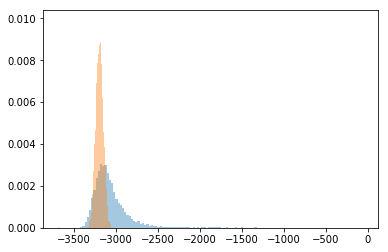

In [27]:
plt.hist(xenergies[xenergies<0],bins=128,normed=True,alpha=0.4);
plt.hist(mm_bpti.energy(sim_x[::20,:]), bins=128,normed=True,alpha=0.4);

Save some samples to a PDB for external visualization

In [29]:
from deep_boltzmann.openmmutils import save_latent_samples_as_trajectory

In [30]:
save_latent_samples_as_trajectory(xsamples[xenergies<0][::10], top, filename="BPTI_BG_SAMPLES.pdb")

<mdtraj.Trajectory with 989 frames, 892 atoms, 58 residues, without unitcells at 0x7fd104120e48>

In [26]:
from pyemma.coordinates import transform

/storage/mi/solsson/miniconda3/lib/python3.7/site-packages/pyemma/util/log.py:58: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  D = yaml.load(f)


In [34]:
tica_out_Bg=tica_project_traj3(xsamples, tica_data_folder+"tica_mean.npy", 
                   tica_data_folder+"tica_cov.npy", tica_data_folder+"tica_covtau.npy",top)
tica_out_sim=tica_project_traj3(sim_x, tica_data_folder+"tica_mean.npy", 
                   tica_data_folder+"tica_cov.npy", tica_data_folder+"tica_covtau.npy",top)

/storage/mi/solsson/miniconda3/envs/p36/lib/python3.6/site-packages/mdtraj/geometry/dihedral.py:374: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  indices = np.vstack(x for x in indices if x.size)[id_sort]
/storage/mi/solsson/miniconda3/envs/p36/lib/python3.6/site-packages/pyemma/coordinates/data/featurization/angles.py:211: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  indices = np.vstack(valid.values())


# Compare free energy landscape of off-equilibrium training data and BG samples

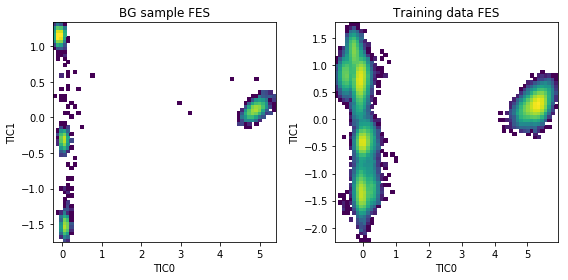

In [45]:
import matplotlib as mpl
fig,ax = plt.subplots(1,2, figsize=(8,4))
ax[0].hist2d(tica_out_Bg[:,0], tica_out_Bg[:,1], bins=64, norm=mpl.colors.LogNorm());
ax[0].set_title("BG sample FES")
ax[0].set_xlabel("TIC0")
ax[0].set_ylabel("TIC1")
ax[1].hist2d(tica_out_sim[:,0], tica_out_sim[:,1], bins=64, norm=mpl.colors.LogNorm());
ax[1].set_title("Training data FES")
ax[1].set_xlabel("TIC0")
ax[1].set_ylabel("TIC1")
fig.tight_layout()